In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import os, sys
import toml
config = toml.load('../../../../configuration/input_configuration.toml')
%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# % Tours by Destination District
# % Trips by Desitnation District
# % People by District

In [2]:
working_dir = r'../../../../outputs/agg/dash'
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

In [3]:
def load_data(fname):
    """ open and join model and survey data """

    df_model = pd.read_csv(os.path.join(working_dir,fname+'.csv'))
    df_model['source'] = 'model'
    df_survey = pd.read_csv(os.path.join(working_dir,'survey',fname+'.csv'))
    df_survey['source'] = 'survey'
    df = df_model.append(df_survey)

    return df

In [4]:
df = load_data('trip_total')

In [5]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../../inputs/db/'+config['db_name'],
        columns=['District','ParcelID'])

In [6]:
district_lookup = {1: 'Suburban Snohomish',
                  2: 'Everett-Lynwood-Edmonds',
                  3: 'North Seattle-Shoreline',
                  4: 'Seattle CBD',
                  5: 'West-South Seattle',
                  6: 'East Side',
                   7: 'Renton-FedWay-Kent',
                   8: 'Tacoma',
                   9: 'Kitsap',
                   10: 'South Pierce',
                   11: 'S.Kitsap'
                  }

# Average Distance by Tour Purpose

source,model,survey
pdpurp,,
Escort,7.18,4.36
Meal,5.93,3.76
Personal Business,6.90,6.63
School,3.87,3.93
Shop,4.57,4.27
Social,4.53,5.63
Work,11.59,11.40


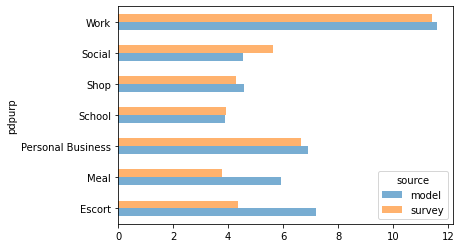

In [7]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('pdpurp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('pdpurp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='pdpurp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='pdpurp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'pdpurp': 'Tour Purpose'}, inplace=True)
# df.drop('Change Mode Inserted Purpose', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Average Distance by Tour Mode

source,model,survey
tmodetp,,
Bike,3.54,2.36
HOV2,7.11,5.93
HOV3+,6.88,6.83
SOV,8.58,8.32
School Bus,3.17,2.93
TNC,2.32,6.93
Transit,8.91,9.18
Walk,0.97,0.84


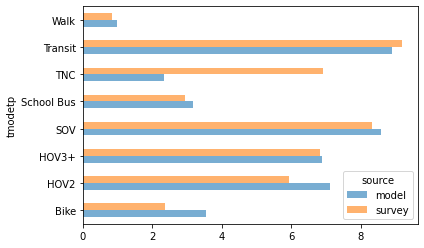

In [8]:
df = load_data('tour_distance')
# Trim any unreasonable survey distances off by taking max distance as max modeled bin value
max_model_dist = df.loc[(df['source']=='model'), 'tautodist_bin'].max()
df = df.loc[df['tautodist_bin'] <= max_model_dist]
df['wt_autodist'] = (df['tautodist_bin']+0.5)*(df['toexpfac'])
df_dist = pd.DataFrame()
for source in ['model','survey']:
    _df = df[(df['source'] == source)]
    df1 = _df.groupby('tmodetp').sum()[['wt_autodist']].reset_index()
    df2 = _df.groupby('tmodetp').sum()[['toexpfac']].reset_index ()
    _df = df1.merge(df2, on='tmodetp')
    _df['commute_distance'] = _df['wt_autodist']/_df['toexpfac']
    _df['source'] = source
    df_dist = df_dist.append(_df)
df = df_dist.pivot_table(index='tmodetp', columns='source', aggfunc='first', values='commute_distance')
df.rename(columns={'tmodetp': 'Tour Mode'}, inplace=True)

df.drop('Park', inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Trips per Tour by Tour Purpose
Average number of trip legs in a tour

source,model,survey
pdpurp,,
Escort,2.64,2.59
Meal,2.19,2.56
Personal Business,2.43,2.76
School,2.58,2.44
Shop,2.45,2.92
Social,2.25,2.76
Work,2.90,3.08


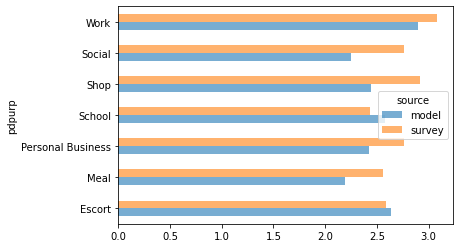

In [9]:
df = load_data('trips_by_tour')
df['wt_tot_trips'] = (df['tripsh1']+df['tripsh2'])*df['toexpfac']

df1 = df.pivot_table(columns='source', index='pdpurp', values='toexpfac', aggfunc='sum')
df2 = df.pivot_table(columns='source', index='pdpurp', values='wt_tot_trips', aggfunc='sum')

df = df2/df1
# df.drop('Change Mode Inserted Purpose', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Trips per Tour by Tour Mode
Average number of trip legs in a tour

source,model,survey
tmodetp,,
Bike,2.46,2.32
HOV2,2.62,2.91
HOV3+,2.56,3.04
SOV,2.50,2.83
School Bus,2.37,2.26
TNC,2.26,2.33
Transit,2.61,2.41
Walk,2.28,2.17


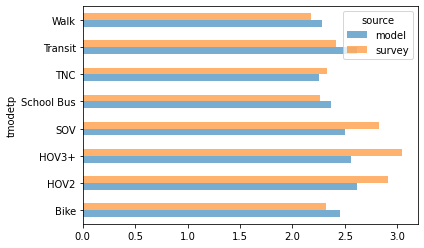

In [10]:
df = load_data('trips_by_tour')
df['wt_tot_trips'] = (df['tripsh1']+df['tripsh2'])*df['toexpfac']

df1 = df.pivot_table(columns='source', index='tmodetp', values='toexpfac', aggfunc='sum')
df2 = df.pivot_table(columns='source', index='tmodetp', values='wt_tot_trips', aggfunc='sum')

df = df2/df1
df.drop('Park', axis=0, inplace=True)
df.plot(kind='barh', alpha=0.6)
df

# Tour Destinations by District
Total tours with primary destinations in each district

,model,survey
Suburban Snohomish,8.21%,8.46%
Everett-Lynwood-Edmonds,7.27%,8.71%
North Seattle-Shoreline,8.84%,9.84%
Seattle CBD,10.94%,8.06%
West-South Seattle,6.20%,6.33%
East Side,17.40%,16.41%
Renton-FedWay-Kent,15.69%,15.46%
Tacoma,7.35%,7.26%
Kitsap,5.93%,5.92%
South Pierce,10.84%,12.20%


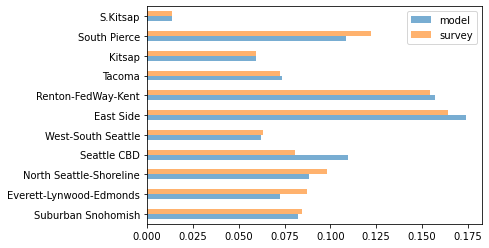

In [11]:
pd.options.display.float_format = '{:0,.2%}'.format

_df = pd.DataFrame()
for id, name in district_lookup.items():
    df = load_data('tour_total_tour_d_district_'+name)
    for source in ['model','survey']:
        _df.loc[name,source] = df[df['source'] == source]['toexpfac'].sum()
        
_df = _df/_df.sum()
_df.plot(kind='barh', alpha=0.6)
_df